# Lecture 3: From Symmetry to Constraint

This notebook accompanies Lecture 3. Its purpose is to make the abstract idea
“equivariance constrains functions” concrete and testable.

You will:
- Test equivariance numerically
- See that linear equivariance = commutation
- Project arbitrary linear maps onto equivariant ones
- Watch translation equivariance turn dense matrices into convolutions
- Observe how symmetry improves generalization (interactive slider)
- (Optional) See a small rotation example in 2D


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Interactive widgets (for the slider section)
import ipywidgets as widgets
from IPython.display import display, clear_output

np.random.seed(0)

def fro_norm(A):
    return np.linalg.norm(A, ord='fro')

def rel_error(A, B, eps=1e-8):
    return fro_norm(A - B) / max(fro_norm(A), fro_norm(B), eps)


## 1. A numerical equivariance test

Equivariance means:

\[
f(g \cdot x) = g \cdot f(x)
\]

For linear maps \(f(x) = Wx\) with matrix actions \(g\), this becomes:

\[
W(gx) = g(Wx) \quad \Longleftrightarrow \quad Wg = gW
\]

We will measure how badly commutation fails.


In [9]:
def equivariance_error_linear(W, G):
    """
    Measures max relative commutation error max_g ||Wg - gW||_F / ||W||_F.
    """
    errs = []
    for g in G:
        errs.append(fro_norm(W @ g - g @ W))
    return max(errs) / max(fro_norm(W), 1e-8)


## 2. Translation symmetry as a finite group

We use circular translations on a 1D grid of length `n`.
Each group element is a permutation matrix \(T^k\).


In [10]:
def shift_matrix(n, k):
    """Circular shift by k as an n×n permutation matrix."""
    P = np.zeros((n, n))
    for i in range(n):
        P[(i + k) % n, i] = 1.0
    return P

n = 16
G_trans = [shift_matrix(n, k) for k in range(n)]

print("n =", n)
print("|G_trans| =", len(G_trans))


n = 16
|G_trans| = 16


## 3. Equivariance = commutation (numerically)

Start with a completely unconstrained linear map \(W\), and measure commutation error.


In [11]:
W = np.random.randn(n, n)
err_before = equivariance_error_linear(W, G_trans)
print(f"Equivariance/commutation error (before): {err_before:.3e}")


Equivariance/commutation error (before): 1.475e+00


## 4. Projecting onto the equivariant subspace

We enforce equivariance by averaging over the group:

\[
\Pi(W) = \frac{1}{|G|}\sum_{g \in G} g\, W\, g^{-1}.
\]

For permutation matrices, \(g^{-1} = g^T\).

This produces the closest (in an averaging sense) map that commutes with every group element.


In [12]:
def project_commuting(W, G):
    W_proj = np.zeros_like(W)
    for g in G:
        W_proj += g @ W @ g.T  # g^{-1} = g^T for permutation matrices
    return W_proj / len(G)

W_proj = project_commuting(W, G_trans)

err_after = equivariance_error_linear(W_proj, G_trans)
print(f"Equivariance/commutation error (after):  {err_after:.3e}")
print(f"Relative change in W:                   {rel_error(W, W_proj):.3e}")


Equivariance/commutation error (after):  2.508e-16
Relative change in W:                   9.808e-01


## 5. Visualizing the constraint

Compare the original dense matrix with the translation-equivariant one.
You should see strong diagonal structure emerge.


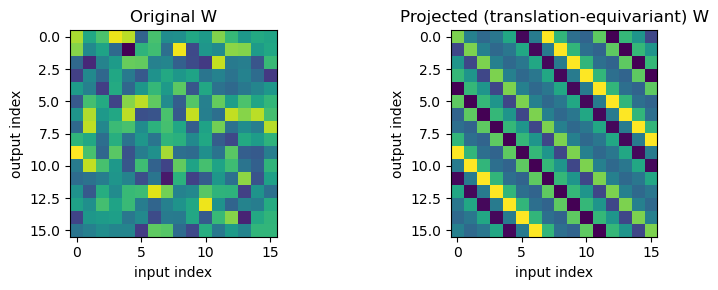

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(W, cmap='viridis')
axes[0].set_title("Original W")
axes[0].set_xlabel("input index")
axes[0].set_ylabel("output index")

axes[1].imshow(W_proj, cmap='viridis')
axes[1].set_title("Projected (translation-equivariant) W")
axes[1].set_xlabel("input index")
axes[1].set_ylabel("output index")

plt.tight_layout()
plt.show()


## 6. Translation equivariance implies convolution (circular)

A translation-equivariant linear map is fully determined by its response to a single impulse.
Let \(e_0\) be an impulse at index 0. Then:

\[
h = W e_0
\]

acts like a circular convolution kernel.


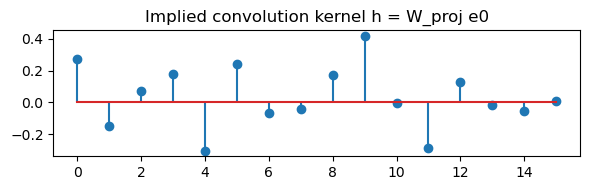

In [15]:
def circ_conv(x, h):
    """Circular convolution using FFT."""
    return np.real(np.fft.ifft(np.fft.fft(x) * np.fft.fft(h)))

e0 = np.zeros(n)
e0[0] = 1.0

h = W_proj @ e0  # implied kernel

plt.figure(figsize=(6, 2))
plt.stem(h)
plt.title("Implied convolution kernel h = W_proj e0")
plt.tight_layout()
plt.show()


In [17]:
x = np.random.randn(n)
y1 = (W_proj @ x).reshape(1,-1)
y2 = circ_conv(x, h).reshape(1,-1)

print("Relative error (W_proj x vs conv(x,h)):", rel_error(y1, y2))


Relative error (W_proj x vs conv(x,h)): 2.1460903636066397e-16


## 7. Learning with and without symmetry (interactive)

We build a learning problem where the *true* map is translation-equivariant:
\[
y = h_{\text{true}} * x
\]
(circular convolution).

We compare:
- **Dense linear regression** (learns an unconstrained matrix \(W\))
- **Convolutional regression** (learns a kernel \(h\), enforced by symmetry)

Use the slider to change the number of training samples \(m\).


In [18]:
# Fix ground truth across all slider settings for comparability
rng = np.random.default_rng(0)
h_true = rng.normal(size=n)

def make_dataset(m, rng):
    X = rng.normal(size=(n, m))
    Y = np.column_stack([circ_conv(X[:, i], h_true) for i in range(m)])
    return X, Y

def fit_dense(X, Y):
    """
    Fit W in Y ≈ W X by least squares.
    Solve X^T W^T ≈ Y^T using lstsq.
    """
    W_hat_T, *_ = np.linalg.lstsq(X.T, Y.T, rcond=None)
    return W_hat_T.T

def fit_conv_kernel_freq(X, Y, ridge=1e-8):
    """
    Fit circular convolution kernel h in frequency domain.

    For each frequency ω:
        H(ω) = sum_i Y(ω,i) conj(X(ω,i)) / (sum_i |X(ω,i)|^2 + ridge)
    """
    Xf = np.fft.fft(X, axis=0)
    Yf = np.fft.fft(Y, axis=0)

    denom = np.sum(np.abs(Xf)**2, axis=1) + ridge
    numer = np.sum(Yf * np.conj(Xf), axis=1)

    H_hat = numer / denom
    h_hat = np.real(np.fft.ifft(H_hat))
    return h_hat

def eval_mse_dense(W_hat, X_test, Y_test):
    Y_pred = W_hat @ X_test
    return np.mean((Y_pred - Y_test)**2)

def eval_mse_conv(h_hat, X_test, Y_test):
    Y_pred = np.column_stack([circ_conv(X_test[:, i], h_hat) for i in range(X_test.shape[1])])
    return np.mean((Y_pred - Y_test)**2)


In [22]:
def run_experiment(m, n_test=200, seed_train=1, seed_test=2, show_plot=True):
    # Separate RNG streams so the slider only changes m
    rng_train = np.random.default_rng(seed_train)
    rng_test = np.random.default_rng(seed_test)

    # Data
    X, Y = make_dataset(m, rng_train)
    X_test = rng_test.normal(size=(n, n_test))
    Y_test = np.column_stack([circ_conv(X_test[:, i], h_true) for i in range(n_test)])

    # Fit models
    W_hat = fit_dense(X, Y)
    h_hat = fit_conv_kernel_freq(X, Y)

    # Evaluate
    mse_dense = eval_mse_dense(W_hat, X_test, Y_test)
    mse_conv  = eval_mse_conv(h_hat, X_test, Y_test)

    if show_plot:
        # Show learned kernels (dense has many dof; show only its impulse response)
        e0 = np.zeros(n); e0[0] = 1.0
        h_from_dense = W_hat @ e0

        plt.figure(figsize=(9, 3))
        plt.subplot(1, 3, 1)
        plt.stem(h_true)
        plt.title("True kernel h_true")

        plt.subplot(1, 3, 2)
        plt.stem(h_hat)
        plt.title(f"Learned kernel (conv), m={m}")

        plt.subplot(1, 3, 3)
        plt.stem(h_from_dense)
        plt.title(f"Impulse response of dense W, m={m}")

        plt.tight_layout()
        plt.show()

    print(f"m = {m:3d} | Test MSE (dense): {mse_dense:.3e} | Test MSE (conv): {mse_conv:.3e}")

# Slider UI
m_slider = widgets.IntSlider(
    value=5, min=2, max=200, step=1,
    description="m (train):", continuous_update=False
)

out = widgets.Output()

def on_change(change):
    if change["name"] == "value":
        with out:
            clear_output(wait=True)
            run_experiment(change["new"], show_plot=True)

m_slider.observe(on_change)

display(m_slider, out)

# Run once at initial value
with out:
    clear_output(wait=True)
    run_experiment(m_slider.value, show_plot=True)


IntSlider(value=5, continuous_update=False, description='m (train):', max=200, min=2)

Output()

## 8. Optional: rotation symmetry in 2D

We repeat the projection idea for the finite rotation group of the square: rotations by 0°, 90°, 180°, 270°.

Commuting with all these rotations is extremely restrictive.


In [23]:
def rotation_matrix(theta):
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta),  np.cos(theta)]])

G_rot = [rotation_matrix(k * np.pi / 2) for k in range(4)]

W2 = np.random.randn(2, 2)
W2_proj = sum(R @ W2 @ R.T for R in G_rot) / len(G_rot)

print("Original W2:\n", W2)
print("\nProjected W2 (commutes with 90° rotations):\n", W2_proj)

# Check commutation error quickly
errs = [fro_norm(W2_proj @ R - R @ W2_proj) for R in G_rot]
print("\nMax commutation error:", max(errs))


Original W2:
 [[ 0.68981816  1.30184623]
 [-0.62808756 -0.48102712]]

Projected W2 (commutes with 90° rotations):
 [[ 0.10439552  0.96496689]
 [-0.96496689  0.10439552]]

Max commutation error: 7.850462293418876e-17


## Summary

- Equivariance can be tested numerically.
- For linear maps, equivariance is commutation: \(Wg = gW\).
- Group averaging projects an arbitrary map onto an equivariant one.
- Translation equivariance forces convolution (here: circular convolution).
- Enforcing symmetry can dramatically improve generalization by eliminating illegal functions.
